# Modeling
---
In this notebook we are running a Logsitic Regression model on our data. We are dropping columns that are not significant predictors by using an F-Regression method. 

In [107]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, accuracy_score, f1_score, roc_auc_score, plot_precision_recall_curve, plot_roc_curve 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [108]:
df = pd.read_csv('Data/model_df.csv')
df.dropna(axis = 1, inplace = True) 
df['stay_calm_2'] = df['stay_calm']**2
df['bullied_2'] = df['BULLIED_R']**2
df['gen_health_2'] = df['gen_health']**2
df['school_prob_2'] = df['school_prob']**2
df['HCABILITY_2'] = df['HCABILITY']**2

X = df.drop(columns = ['depression' ,'anxiety', 'dep_anx_hist']) # target cols
y = df['dep_anx_hist'] # target col

In [109]:
# perform f_regression on features to remove low significance features
drop_cols = pd.DataFrame(zip(X.columns, f_regression(X, y)[1])).sort_values(by = 1, ascending = False)[:60][0].values

model_X = X.drop(columns = drop_cols)

analysis_X = X.drop(columns = drop_cols)

# Imbalanced Data
The undersampler worked best with our data. SMOTE introduced too much noise, and oversampling changed the variance of our patient population too much. 

----

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(model_X, y, stratify = y, test_size = .3)

# under sample
und = RandomUnderSampler()
X_train_under, y_train_under = und.fit_resample(X_train, y_train)

# Logistic Regression
I created a GridSearch pipeline to solve for the best values of C and the L1 Ratio in the elasticnet model. I used recall, f1-score, and roc-auc score as scoring metrics for the GridSearch until I optimized recall without compromising precision too much. I chose to optimize recall since comparatively, the proportion of miscalssified "healthy" adolescents is very small to the actual non-patient population. Optimistically, these individuals could have been misclassified since they are "at risk" for developing depression and anxiety. Most people that have these disorders develop them in their adolescence, but not always. The goal is to find factors that predict Depression and Anxiety, not to diagnose people. 

In [64]:
# pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'ss__with_mean'     : [True],
    'ss__with_std'      : [True],
    'lr__penalty'      : ['elasticnet'],
    'lr__C'            : np.linspace(.01, .023, 20),
    'lr__solver'       : ['saga'],
    'lr__l1_ratio'     : [0]
}

# gridsearch
gs = GridSearchCV(pipe, pipe_params, cv = 3, verbose = 1, scoring = 'recall', return_train_score=True)

# fit model
gs.fit(X_train_under, y_train_under)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(max_iter=5000))]),
             param_grid={'lr__C': array([0.01      , 0.01068421, 0.01136842, 0.01205263, 0.01273684,
       0.01342105, 0.01410526, 0.01478947, 0.01547368, 0.01615789,
       0.01684211, 0.01752632, 0.01821053, 0.01889474, 0.01957895,
       0.02026316, 0.02094737, 0.02163158, 0.02231579, 0.023     ]),
                         'lr__l1_ratio': [0], 'lr__penalty': ['elasticnet'],
                         'lr__solver': ['saga'], 'ss__with_mean': [True],
                         'ss__with_std': [True]},
             return_train_score=True, scoring='recall', verbose=1)

In [65]:
gs.best_params_

{'lr__C': 0.020263157894736844,
 'lr__l1_ratio': 0,
 'lr__penalty': 'elasticnet',
 'lr__solver': 'saga',
 'ss__with_mean': True,
 'ss__with_std': True}

TRAIN ACC: 0.8283333333333334
TEST ACC: 0.8626373626373627

TRAIN PREC: 0.8648148148148148
TEST PREC: 0.6020408163265306

TRAIN RECALL: 0.7783333333333333
TEST RECALL: 0.8019417475728156

TRAIN ROC-AUC: 0.8283333333333333
TEST ROC-AUC: 0.8393455916193648


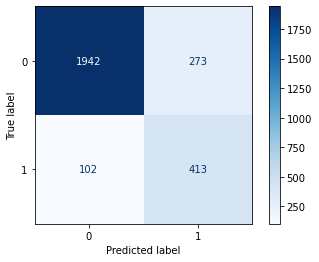

In [66]:
# scale data
ss = StandardScaler(with_mean=True, with_std=True)
X_train_under = ss.fit_transform(X_train_under)
X_test = ss.transform(X_test)

# fit model
lr = LogisticRegression(C = 0.020263157894736844, l1_ratio =  0, penalty = 'elasticnet', solver = 'saga', max_iter = 10_000)
lr.fit(X_train_under, y_train_under)

# print metrics
print('TRAIN ACC:', lr.score(X_train_under, y_train_under))
print('TEST ACC:', lr.score(X_test, y_test))
print()
print('TRAIN PREC:', precision_score(y_train_under, lr.predict(X_train_under)))
print('TEST PREC:', precision_score(y_test, lr.predict(X_test)))
print()
print('TRAIN RECALL:', recall_score(y_train_under, lr.predict(X_train_under)))
print('TEST RECALL:', recall_score(y_test, lr.predict(X_test)))
print()
print('TRAIN ROC-AUC:', roc_auc_score(y_train_under, lr.predict(X_train_under)))
print('TEST ROC-AUC:', roc_auc_score(y_test, lr.predict(X_test)))
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues');

In [85]:
# visualize largest coefficients
pd.DataFrame(np.abs(lr.coef_[0]), columns = ['beta'], index = model_X.columns).sort_values(by = 'beta', ascending = False)[:20]

,beta
mental_treat,0.614415
psych_meds,0.483669
psych_counseling,0.456495
HEADACHE_1,0.273920
stay_calm,0.261265
sex,0.261046
child_race_2.0,0.258037
HCABILITY,0.242490
BULLIED_R,0.195285
adult_avg_menthealth,0.162231


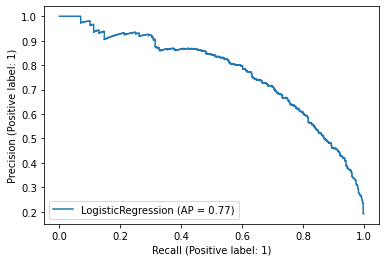

In [86]:
plot_precision_recall_curve(lr, X_test, y_test)

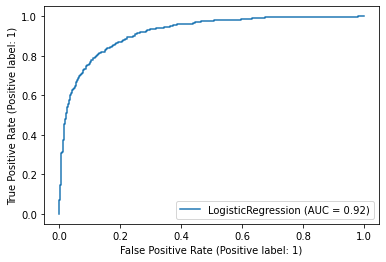

In [87]:
plot_roc_curve(lr, X_test, y_test)

# Visualizing Differences in Key Predictors

In [88]:
def plot_diff(df, target, cols):
    plt.figure(figsize = (30, 20))
    for i, col in enumerate(cols):
        a = df.loc[df[target] == 1, col]
        b = df.loc[df[target] == 0, col]
        plt.subplot(3, 6, i+1)
        sns.barplot(data = df, x = target, y = col)
        plt.xlabel('History of Dep/Anx')

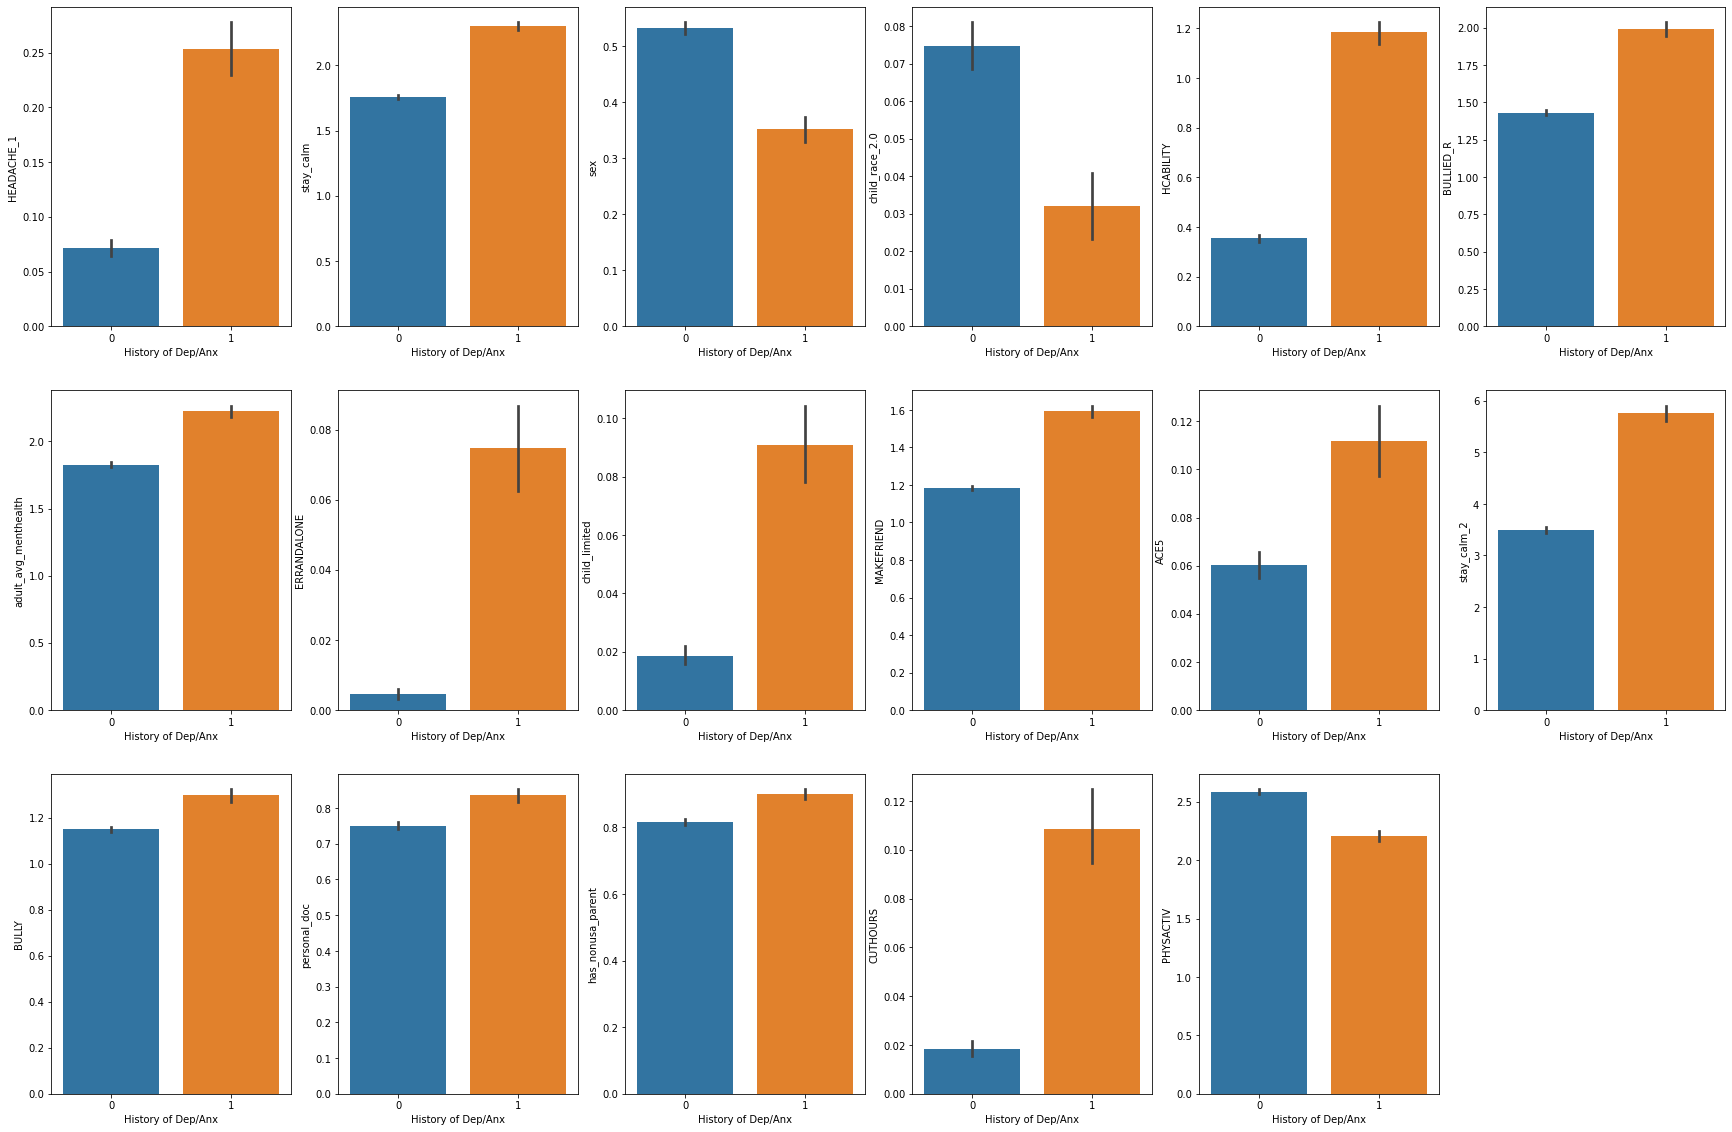

In [93]:
t_test_cols = list(pd.DataFrame(np.abs(lr.coef_[0]), columns = ['beta'], index = model_X.columns).sort_values(by = 'beta', ascending = False)[3:20].index)
plot_diff(df, 'dep_anx_hist', t_test_cols)

# Misclassified Analysis

In [110]:
ss = StandardScaler(with_mean=True, with_std=True)
model_X_sc = ss.fit_transform(model_X)
preds = lr.predict(model_X_sc)
analysis_X['actual'] = y
analysis_X['predicted'] = preds

In [149]:
def plot_diff(df, target, cols, hue):
    plt.figure(figsize = (30, 20))
    for i, col in enumerate(cols):
        a = df.loc[df[target] == 1, col]
        b = df.loc[df[target] == 0, col]
        plt.subplot(3, 6, i+1)
        sns.barplot(data = df, x = target, y = col, hue = hue, palette = ['navy', 'lightblue'])
        plt.xlabel('History of Dep/Anx')

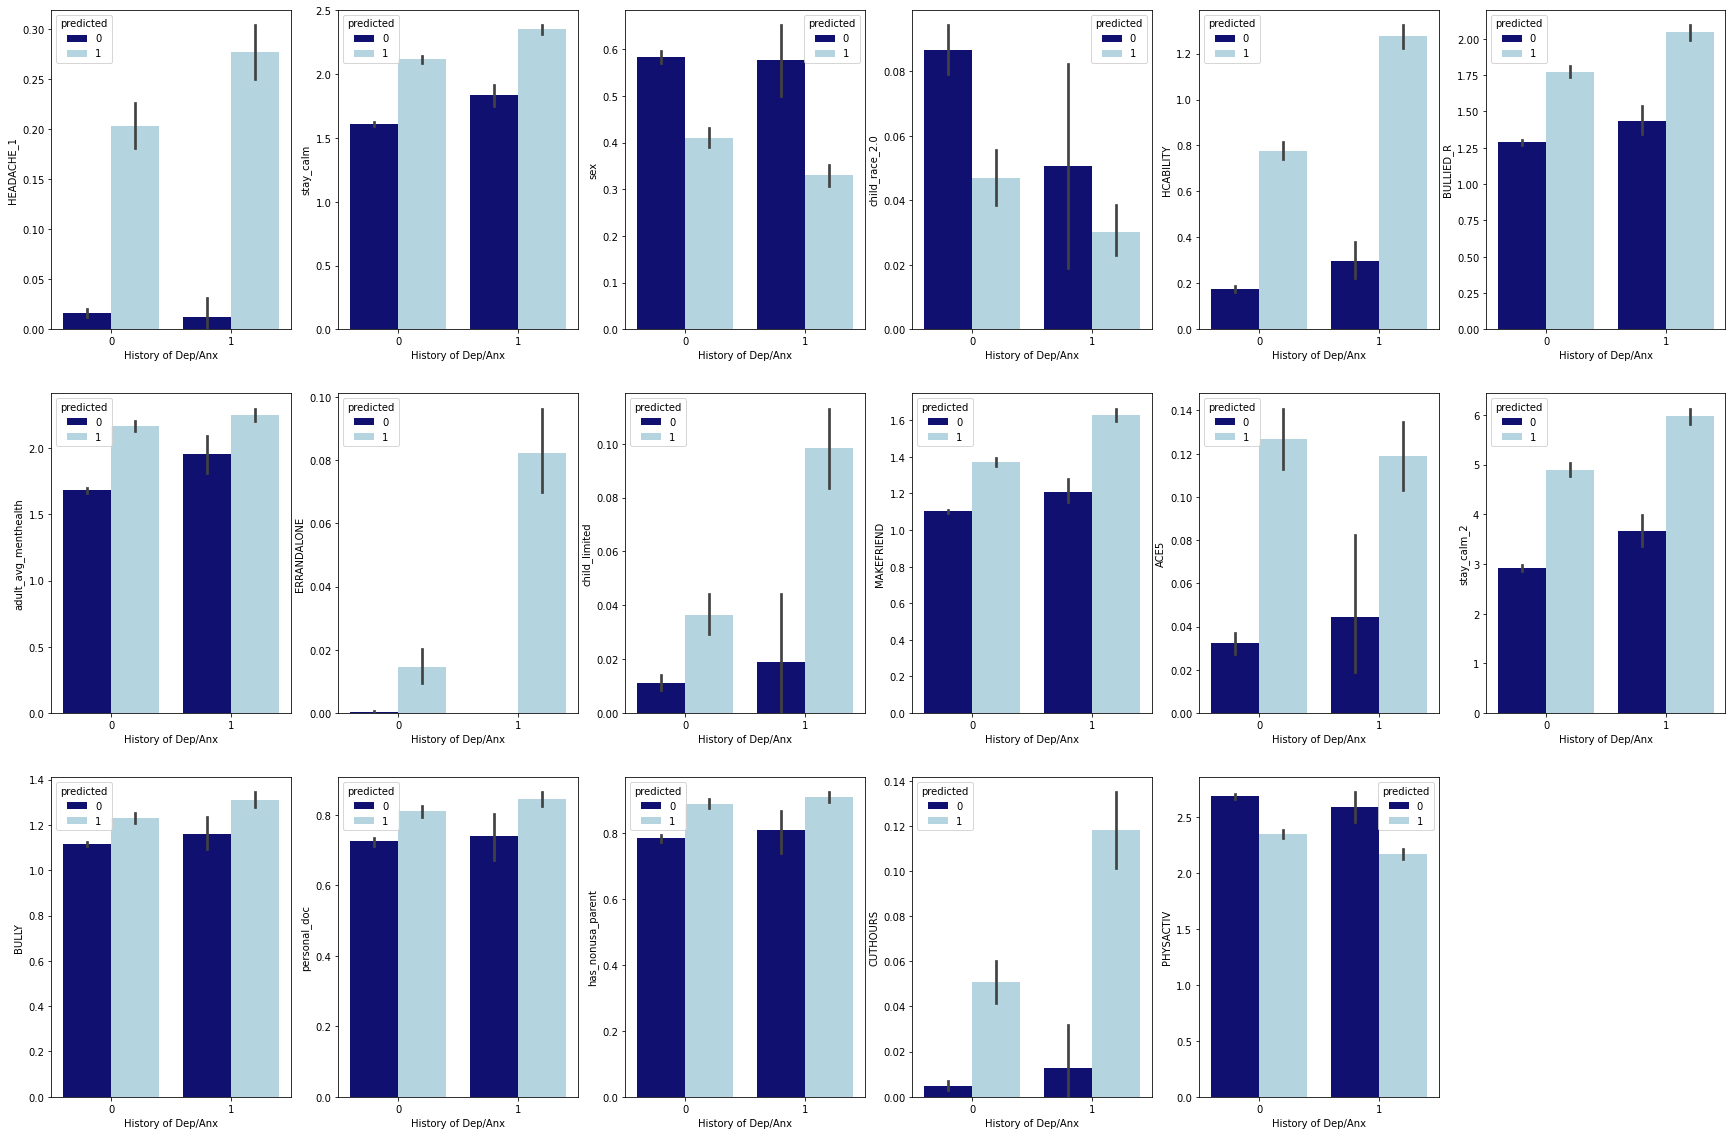

In [150]:
plot_diff(analysis_X, 'actual', t_test_cols, 'predicted')

# Overall Model Performance

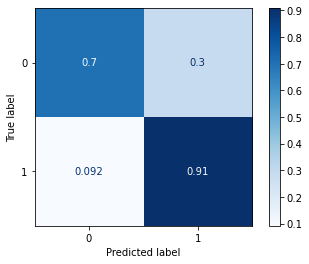

In [153]:
plot_confusion_matrix(lr, model_X_sc, y, normalize = 'true', cmap='Blues');

In [154]:
print('Accuracy:', lr.score(model_X_sc, y))
print()
print('Precision:', precision_score(y, preds))
print()
print('Recall:', recall_score(y, preds))
print()
print('ROC/AUC:', roc_auc_score(y, preds))

Accuracy: 0.7431021215785424

Precision: 0.4167558886509636

Recall: 0.9078717201166181

ROC/AUC: 0.8063471307166672
